In [1]:
# a (graphless) feedforward neural network
# to test the hypothesis that graph structure
# affects tree stability learning

In [2]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
with open('wolfGraphSU.pkl','rb') as q:
    dataq = pickle.load(q)
    SU_trees = dataq['SU_trees']
    wolfGraph = dataq['wolfGraph']
print("loaded!")

loaded!


In [5]:
# multi-layer perceptron (no graph network!)

class SimpleMLP(nn.Module):
    def __init__(self, num_features=10, hidden_dim=64, num_classes=2):
        super(SimpleMLP, self).__init__()

        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x is pit node features, no graph structure
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [13]:
# create dataset (pit features only)
pit_features = []
pit_labels = []

for pit_idx in SU_trees.keys():
    tree = SU_trees[pit_idx]
    pit_node = [n for n in tree.nodes() if tree.out_degree(n) == 0][0]

    # extract 10 features at pit
    feat = [
        #wolfGraph.nodes[pit_node]['elev'],
        wolfGraph.nodes[pit_node].get('max_vel', 0.0),
        #wolfGraph.nodes[pit_node].get('mean_vel', 0.0),
        wolfGraph.nodes[pit_node].get('std_vel', 0.0),
        #wolfGraph.nodes[pit_node].get('mean_erosive_power', 0.0),
        #wolfGraph.nodes[pit_node].get('max_erosive_power', 0.0),
        wolfGraph.nodes[pit_node].get('tidal_range', 0.0),
        #tree.nodes[pit_node].get('total_inflow', 0.0),
        #tree.nodes[pit_node].get('mean_inflow', 0.0),
        #tree.nodes[pit_node].get('max_inflow', 0.0)
    ]

    stability = wolfGraph.nodes[pit_idx]['stability']
    label = 0 if stability == 'S' else 1

    pit_features.append(feat)
    pit_labels.append(label)

# convert to torch tensors
X = torch.tensor(pit_features, dtype=torch.float)
y = torch.tensor(pit_labels, dtype=torch.long)

num_feats = X.shape[1]
print(f"dataset: {len(X)} samples, {num_feats} features, {len(y)} labels")

dataset: 459 samples, 3 features, 459 labels


In [14]:
# train with standard PyTorch -- no gnn

In [15]:
# split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# setup
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [17]:
# model
mlp = SimpleMLP(num_features=num_feats, hidden_dim=64, num_classes=2).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
criterion = nn.NLLLoss()

In [18]:
# train
epochs = 200

# Initialize tracking
train_losses = []
train_accs = []
test_accs = []

for epoch in range(1, epochs+1):
    # training
    mlp.train()
    optimizer.zero_grad()
    out = mlp(X_train.to(device))
    loss = criterion(out, y_train.to(device))
    loss.backward()
    optimizer.step()

    # calculate train accuracy
    pred_train = out.argmax(dim=1)
    train_acc = (pred_train == y_train.to(device)).float().mean().item()

    # calculate test accuracy
    mlp.eval()
    with torch.no_grad():
        test_out = mlp(X_test.to(device))
        pred = test_out.argmax(dim=1)
        test_acc = (pred == y_test.to(device)).float().mean()

    # store metrics
    train_losses.append(loss.item())
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: test acc = {test_acc:.4f}")

print(f"\nfinal test accuracy: {test_accs[-1]:.4f}")

Epoch 20: test acc = 0.5000
Epoch 40: test acc = 0.5435
Epoch 60: test acc = 0.5435
Epoch 80: test acc = 0.6413
Epoch 100: test acc = 0.6413
Epoch 120: test acc = 0.6848
Epoch 140: test acc = 0.6957
Epoch 160: test acc = 0.7174
Epoch 180: test acc = 0.7391
Epoch 200: test acc = 0.7500

final test accuracy: 0.7500


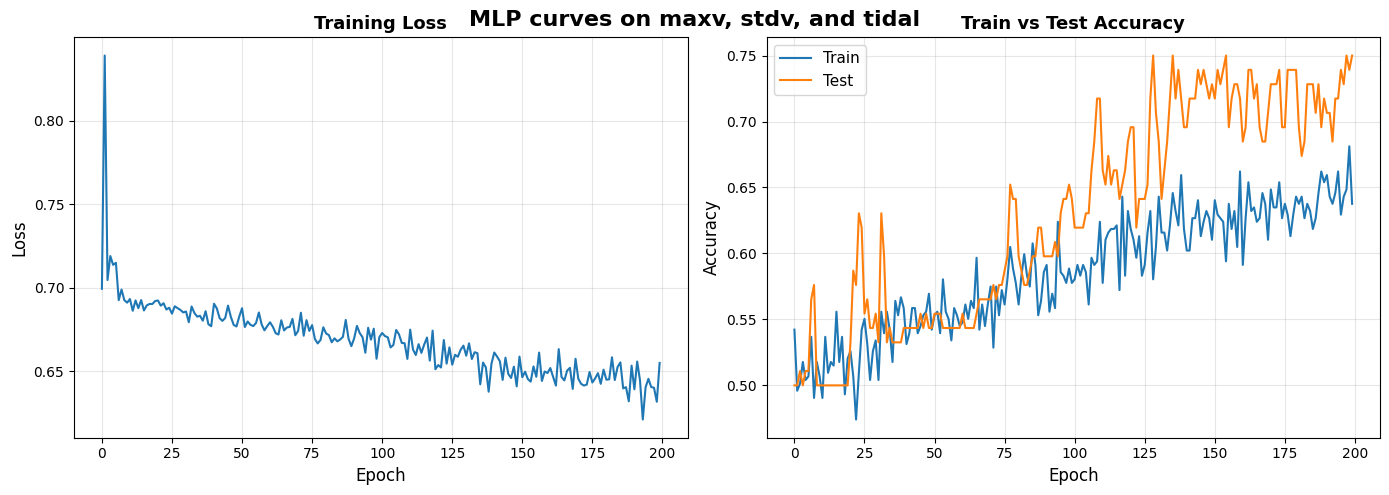

In [28]:
# plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(train_losses, linewidth=1.5)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(train_accs, label='Train', linewidth=1.5)
ax2.plot(test_accs, label='Test', linewidth=1.5)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Train vs Test Accuracy', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"MLP curves on maxv, stdv, and tidal",fontsize=16,fontweight='bold')
#plt.savefig('mlp_training_3hydro.png', dpi=300, bbox_inches='tight')
plt.show()

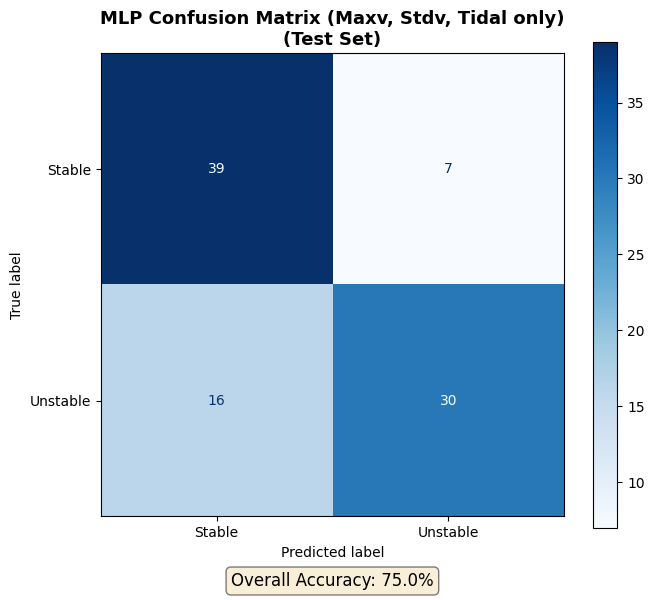


=== MLP Per-Class Performance ===
Stable: 84.8% (39/46)
Unstable: 65.2% (30/46)


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get final predictions
mlp.eval()
with torch.no_grad():
    final_out = mlp(X_test.to(device))
    final_pred = final_out.argmax(dim=1).cpu().numpy()

# Confusion matrix
cm = confusion_matrix(y_test.numpy(), final_pred)

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['Stable', 'Unstable'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('MLP Confusion Matrix (Maxv, Stdv, Tidal only)\n(Test Set)', 
            fontsize=13, fontweight='bold')

# Add accuracy
acc = np.trace(cm) / np.sum(cm)
ax.text(0.5, -0.15, f'Overall Accuracy: {acc:.1%}', 
        transform=ax.transAxes, ha='center', fontsize=12,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
#plt.savefig('mlp_confusion_3hydro.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class stats
print("\n=== MLP Per-Class Performance ===")
for i, label in enumerate(['Stable', 'Unstable']):
    class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    print(f"{label}: {class_acc:.1%} ({cm[i, i]}/{cm[i, :].sum()})")